# Profiling lidar setup

In [1]:
# Load the amrwind-frontend module
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/ascldap/users/lcheung/wind_uq/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

# Load the libraries
import amrwind_frontend  as amrwind
import matplotlib.pyplot as plt
import numpy             as np
import math
import pandas as pd
import postproamrwindsample as ppsample
import time
import utm
from IPython.display import display, Markdown, Latex

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

In [2]:
ORIGsummitcsv          = 'UnstableABL_farmrun_turbines.csv'
NEWsummitcsv           = 'UnstableABL_farmrun_turbines2.csv'

In [3]:
NEWallturbsdf  = pd.read_csv(NEWsummitcsv, low_memory=False)

subset = [] 
for x in NEWallturbsdf.iterrows():
    if x[1]['# name'].endswith('-AF') or x[1]['# name'].endswith('-KP'):
        subset.append(x[1])
NEWsubsetdf = pd.DataFrame(subset[:])

## Information from Nicola and Stefano's emails 

Information from Nicola:

```
We have lidars at:
-	Site A1 36°21'43.6"N 97°24'16.4"W  (Vertical prof)
-	Site A2 36°19'05.5"N 97°24'32.7"W  (Vertical prof)
-	Site A5 36°21'42.5"N 97°22'53.8"W
-	Site A7 36°20'49.2"N 97°23'23.3"W
-	Site B 36°13'54.4"N 97°33'31.2"W  (Vertical prof)
-	Site C1a 36°21'41.8"N 97°30'36.1"W (Vertical prof)
-	Site D 36°22'47.80"N, 97°38'47.31"W (Vertical prof)
-	Site H 36°26'12.7"N 97°24'27.9"W (Vertical prof)
-	Radar 1 36°23'49.8"N 97°43'29.2"W

Only the sites in bold have a vertical profiling lidar (some with scanning lidars, too). The other sites only have scanning lidars not doing vertical profiles.

Sites E and G never had (and likely never will) have (profiling) lidars deployed.

Thanks,
Nicola
```
----
```
•	site A5 doesn’t have a profiling lidar anymore
•	Site A5 has a new scanning lidar which will also be used to add a second virtual tower near site E
•	Site C1a also has UTD’s scanning lidars (doing a variety of scans)
•	Radar site 1 also has a scanning lidar (not sure about the scanning strategy there)
```
---
```
PL=profiling lidar (measures u,v,w from ~40 m to ~200 m every ~4 s)
SL= scanning lidar (measures u,v,w from ~100 m to ~1000 m every ~20 s+Reynolds stresses)
VT= virtual tower (measures u,v from ~20 m to ~300 m every 30 s but without any spatial averaging)
```


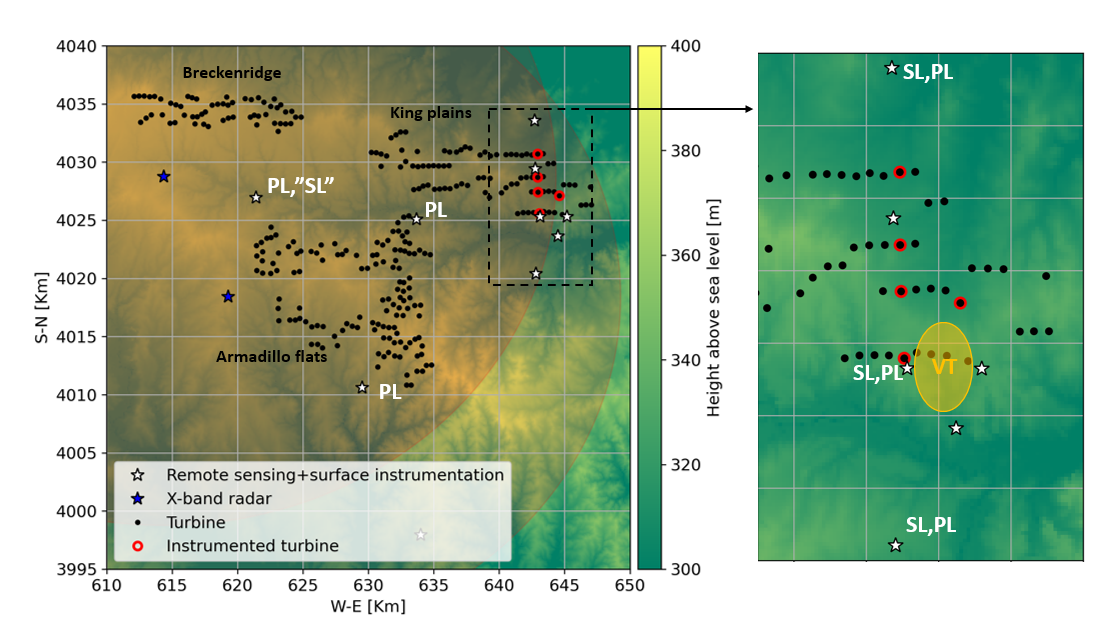

## Now convert that into python friendly format

In [4]:
"""
-	Site A1 36°21'43.6"N 97°24'16.4"W  (Vertical prof)
-	Site A2 36°19'05.5"N 97°24'32.7"W  (Vertical prof)
-	Site A5 36°21'42.5"N 97°22'53.8"W
-	Site A7 36°20'49.2"N 97°23'23.3"W
-	Site B 36°13'54.4"N 97°33'31.2"W  (Vertical prof)
-	Site C1a 36°21'41.8"N 97°30'36.1"W (Vertical prof)
-	Site D 36°22'47.80"N, 97°38'47.31"W (Vertical prof)
-	Site H 36°26'12.7"N 97°24'27.9"W (Vertical prof)
-	Radar 1 36°23'49.8"N 97°43'29.2"W
"""
site_xy   = [{'name':'A1', 'lat':(36,21,43.6), 'long':(97,24,16.4), 'note':'SL,PL',},
             {'name':'A2', 'lat':(36,19,05.5), 'long':(97,24,32.7), 'note':'SL,PL',},
             {'name':'A5', 'lat':(36,21,42.5), 'long':(97,22,53.8), 'note':'SL',},
             {'name':'A7', 'lat':(36,20,49.2), 'long':(97,23,23.3), 'note':'',},
             {'name':'B',  'lat':(36,13,54.4), 'long':(97,33,31.2), 'note':'PL',},
             {'name':'C1a', 'lat':(36,21,41.8), 'long':(97,30,36.1), 'note':'PL',},
             {'name':'D',  'lat':(36,22,47.80), 'long':(97,38,47.31), 'note':'PL,SL',},
             {'name':'H',   'lat':(36,26,12.7), 'long':(97,24,27.9), 'note':'SL,PL',},
             {'name':'Radar1', 'lat':(36,23,49.8), 'long':(97,43,29.2), 'note':'SL',},
             #{'name':'H', 'long':-97.405716, 'lat':36.437261},
             #{'name':'E', 'long':-97.406248, 'lat':36.379412},
             #{'name':'G', 'long':-97.405855, 'lat':36.410075},
            ]

# Convert  deg/min/sec to decimal
dms2dec = lambda x: x[0] + x[1]/60.0 + x[2]/3600.0
# Add UTM coordinates
for site in site_xy:
    longsign = -1
    site['utm'] = utm.from_latlon(dms2dec(site['lat']), longsign*dms2dec(site['long']))

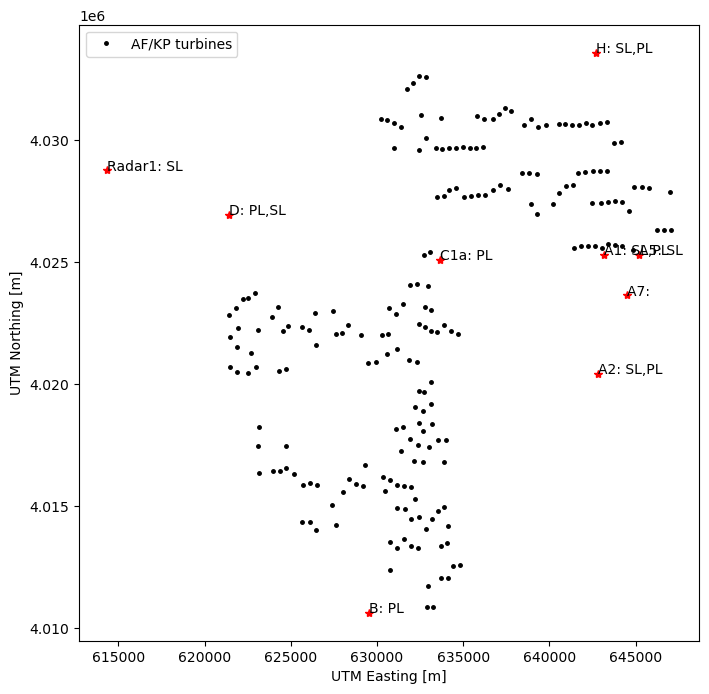

In [5]:
# Make a plot
plt.figure(figsize=(8,8))
NEWxy = np.array([[row[1][' x'], row[1][' y']] for row in NEWsubsetdf.iterrows()])

plt.plot(NEWxy[:,0], NEWxy[:,1],    'k.',   ms=5, label='AF/KP turbines')

for site in site_xy: 
    plt.plot(site['utm'][0], site['utm'][1], 'r*')
    plt.text(site['utm'][0], site['utm'][1], site['name']+': '+site['note'])
    
    
plt.xlabel('UTM Easting [m]')
plt.ylabel('UTM Northing [m]')
plt.legend()